In [1]:
import pandas as pd
import numpy as np
import pysam
import matplotlib.pylab as plt
import sys
sys.path.append('/home1/rahmanin/repositories/basenji/basenji')
from dna_io import dna_1hot
from scipy.stats import pearsonr
import models as mod
import OccupancyInputCTCF.utils as util

2024-12-22 13:16:10.477924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-22 13:16:10.578511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-22 13:16:10.578548: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-22 13:16:11.699415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

### importing data, sequences, ctcf dataframe, bound fraction

In [2]:
bind_sites_filepath = 'data/sonmezer_dataset_CTCT_binding.sites.filtered.mm10.tsv'
bind_freqs_filepath = 'data/binding.frequencies.tsv'
ref_genome_filepath = '/project/fudenber_735/genomes/mm10/mm10.fa'

ref_genome = pysam.FastaFile(ref_genome_filepath)
bind_sites = pd.read_table(bind_sites_filepath)
bind_freqs = pd.read_table(bind_freqs_filepath)


In [3]:
# filtering sites with provided all three frequencies
site_filter = []
for tfbs in bind_freqs['TFBS_cluster'].unique():
       if len(bind_freqs[bind_freqs['TFBS_cluster'] == tfbs]) == 3:
              site_filter.append(tfbs)              
bind_sites = bind_sites[bind_sites.rownames.isin(site_filter)]
bind_sites_revised= bind_sites.rename(columns={'rownames':'TFBS_cluster'})
bind_freqs_dtf = bind_freqs[bind_freqs.TFBS_cluster.isin(site_filter)]

In [4]:
bind_freqs_pivot = bind_freqs_dtf.pivot_table(index='TFBS_cluster', columns='biological.state', values='Freqs', aggfunc='first')
bind_freqs_pivot.reset_index(inplace=True)
bind_freqs_pivot = bind_freqs_pivot[['TFBS_cluster','Accessible','Bound', 'Nucleosome.occupied']]
states = bind_freqs['biological.state'].unique()
#freqs_pivot = bind_freqs.pivot(index='TFBS_cluster', columns='biological.state', values='Freqs')
#bind_freqs_pivot

In [5]:
binds_sites_freqs = pd.merge(bind_sites_revised, bind_freqs_pivot, on='TFBS_cluster', how='left')
binds_sites_freqs.to_csv('sites_with_freqs.tsv',sep='\t')
binds_sites_freqs

,chrom,start,end,width,strand,score,phyloP,rmsk,name,isBound,TF,chipseq.score,TFBS_cluster,Accessible,Bound,Nucleosome.occupied
0,chr1,9541413,9541431,19,-,13.2902,-0.022579,False,CTCF,True,CTCF,401.092987,TFBS_1000,0.503958,0.226913,0.269129
1,chr1,9541469,9541487,19,-,13.2902,0.385316,False,CTCF,True,CTCF,401.092987,TFBS_1001,0.578275,0.271565,0.150160
2,chr1,9545334,9545352,19,-,17.1224,0.913684,False,CTCF,True,CTCF,255.647003,TFBS_1002,0.742331,0.214724,0.042945
3,chr1,11140105,11140123,19,-,13.0579,-0.025105,False,CTCF,True,CTCF,163.445999,TFBS_1005,0.390026,0.052430,0.557545
4,chr1,13500664,13500682,19,-,19.2467,-0.194895,False,CTCF,True,CTCF,299.652008,TFBS_1012,0.500000,0.032338,0.467662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,chr19,60144531,60144549,19,-,17.8472,2.567421,False,CTCF,True,CTCF,351.207001,TFBS_29317,0.287356,0.574713,0.137931
8920,chr19,60161071,60161089,19,-,17.3056,1.536789,False,CTCF,True,CTCF,486.821991,TFBS_29318,0.357143,0.349206,0.293651
8921,chr19,60310788,60310806,19,-,18.2240,1.475263,False,CTCF,True,CTCF,295.570007,TFBS_29319,0.597561,0.341463,0.060976
8922,chr19,60341678,60341696,19,-,20.4797,2.085368,False,CTCF,True,CTCF,271.229004,TFBS_29321,0.316667,0.600000,0.083333


### making labels and features

In [51]:
### making sequences
sequences = []
flank = 30 # considering 300 bp at each side of ctcfs
for idx, row in binds_sites_freqs.iterrows():
       chrom, start, end, rownames = row[['chrom', 'start', 'end', 'TFBS_cluster']]
       seq = (ref_genome.fetch(chrom, int(start - flank), int(end + flank)))
        # Skip sequences containing 'N'
       if 'N' in seq:
            continue
       sequences.append(seq)
    
### making labels
frequency_columns = ['Accessible', 'Bound', 'Nucleosome.occupied']

# Select only the frequency columns
frequencies_df = binds_sites_freqs[frequency_columns]

# Convert the selected columns to a NumPy array
frequencies_array = frequencies_df.to_numpy()
freqs = frequencies_array

### processing the sequences

In [52]:
from OccupancyInputCTCF.utils.ml import dna_1hot
input_features = []
for sequence in sequences[:]:
    one_hot_encoded = dna_1hot(sequence)
    input_features.append(one_hot_encoded.astype(int))
input_features = np.stack(input_features)    

In [53]:
# we can use eithor or all of the info about accessibility, bound fraction, and nucleosome occupied

In [54]:
freqs_bound = freqs[:,1]
freqs_accessible = freqs[:,0]
freqs_nucleosome = freqs[:,2]

In [55]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features,
    freqs_bound,
    test_size=0.25,
    random_state=35
)


### using bound fraction

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def Regressionmodel(features, learningrate, dense_layers = 1, activation=None, regularization_strength=0.01):
    model = Sequential()
    model.add(Input(shape=(features.shape[1], features.shape[2])))
    model.add(Flatten())
    
    # Add the dense layer with the given activation and regularization (if specified)
    model.add(Dense(1, activation=activation, kernel_regularizer=l2(regularization_strength))) 
    
    # Compile the model with MSE loss for continuous target values
    model.compile(optimizer=Adam(learning_rate=learningrate), loss='mean_squared_error')
    
    return model

70/70 [==============================] - 0s 418us/step


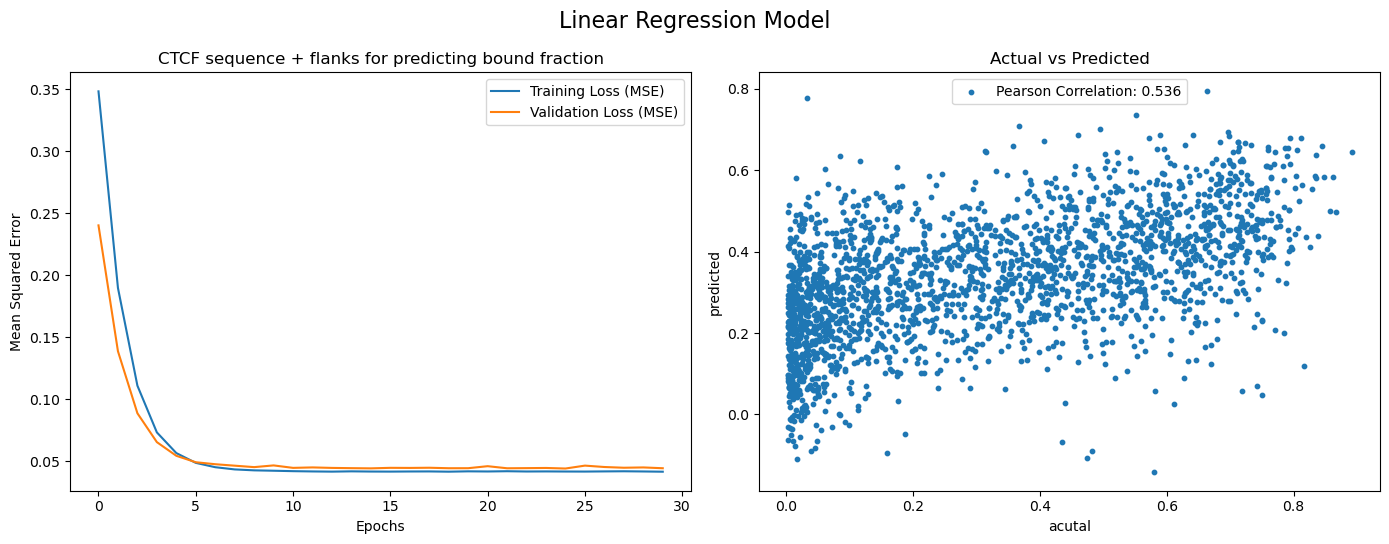

In [82]:
model = Regressionmodel(train_features, 0.001, regularization_strength = 0)
history = model.fit(train_features, train_labels,
                             epochs = 30, batch_size=128, 
                             validation_data = (test_features, test_labels),verbose=0)

# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']
val_predictions = model.predict(test_features)
pearson_corr, _ = pearsonr(test_labels, val_predictions.flatten())


### plots
fig, axes = plt.subplots(1,2,figsize = (14,5.5))

axes[1].scatter(test_labels, val_predictions,s=10, label=f'Pearson Correlation: {pearson_corr:.3f}')
axes[1].set_xlabel('acutal')
axes[1].set_ylabel('predicted')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()

axes[0].plot(mse, label='Training Loss (MSE)')
axes[0].plot(val_mse, label='Validation Loss (MSE)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].set_title('CTCF sequence + flanks for predicting bound fraction')




fig.suptitle('Linear Regression Model', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


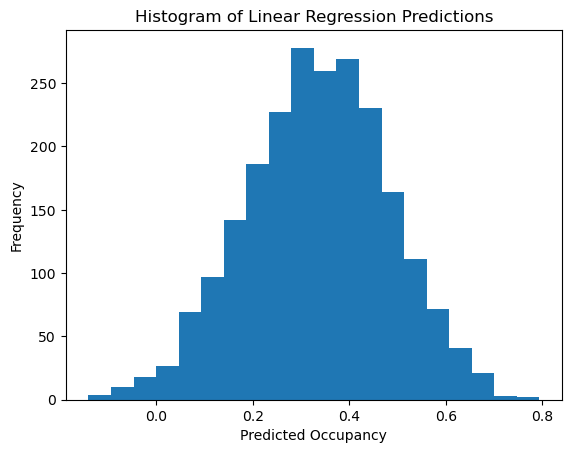

In [83]:
plt.hist(val_predictions, bins=20)
plt.title("Histogram of Linear Regression Predictions")
plt.xlabel("Predicted Occupancy")
plt.ylabel("Frequency")
plt.show()

70/70 [==============================] - 0s 419us/step


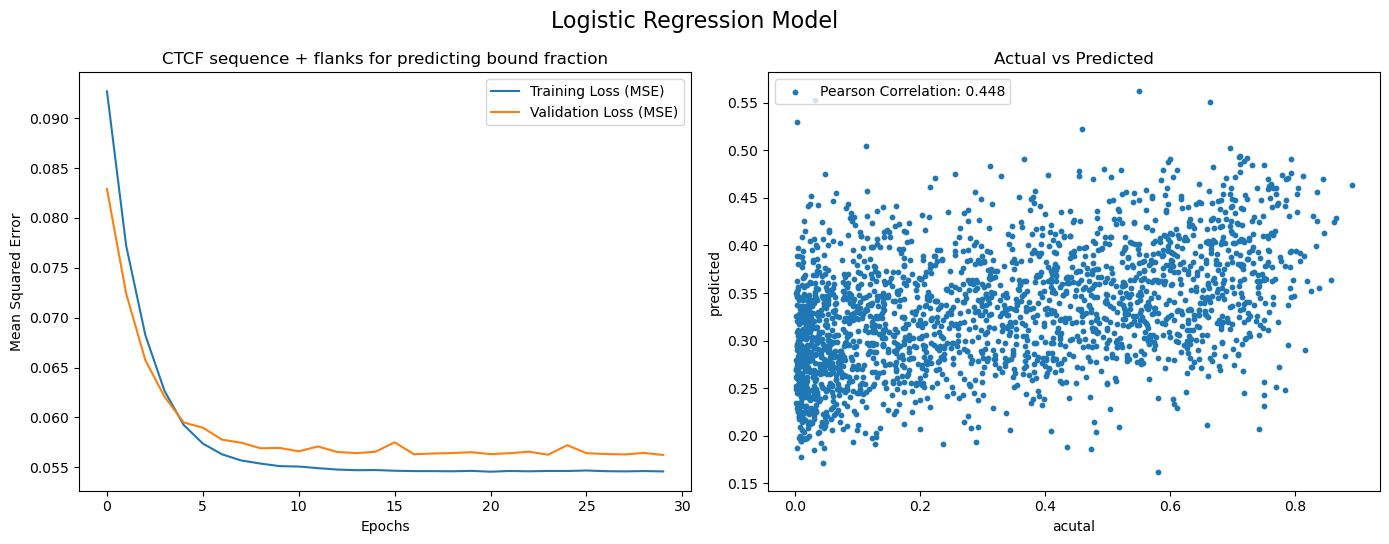

In [84]:
model = Regressionmodel(train_features, 0.001, activation = 'sigmoid', regularization_strength=0.01)

history = model.fit(train_features, train_labels,
                             epochs = 30, batch_size=128, 
                             validation_data = (test_features, test_labels),verbose=0)

# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']
val_predictions = model.predict(test_features)
pearson_corr, _ = pearsonr(test_labels, val_predictions.flatten())


### plots
fig, axes = plt.subplots(1,2,figsize = (14,5.5))

axes[1].scatter(test_labels, val_predictions,s=10, label=f'Pearson Correlation: {pearson_corr:.3f}')
axes[1].set_xlabel('acutal')
axes[1].set_ylabel('predicted')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()

axes[0].plot(mse, label='Training Loss (MSE)')
axes[0].plot(val_mse, label='Validation Loss (MSE)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].set_title('CTCF sequence + flanks for predicting bound fraction')




fig.suptitle('Logistic Regression Model', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


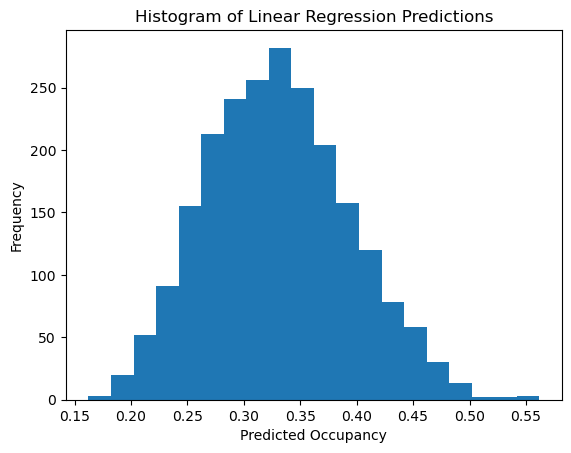

In [85]:
plt.hist(val_predictions, bins=20)
plt.title("Histogram of Linear Regression Predictions")
plt.xlabel("Predicted Occupancy")
plt.ylabel("Frequency")
plt.show()

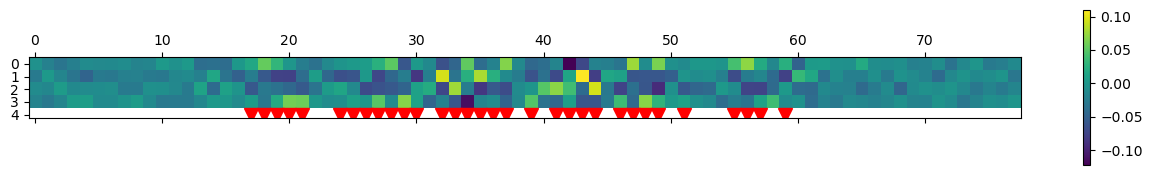

In [86]:
threshold = 0.053

weights = model.layers[-1].weights[0].numpy().reshape((len(seq), 4)).T

column_mask = np.any(np.abs(weights) > threshold, axis=0)

plt.matshow(weights, cmap='viridis')
plt.colorbar()

for col in range(weights.shape[1]):
    if column_mask[col]:  
        plt.plot(col, weights.shape[0], 'rv', markersize=10)  
plt.show()

### using accessibility

70/70 [==============================] - 0s 416us/step


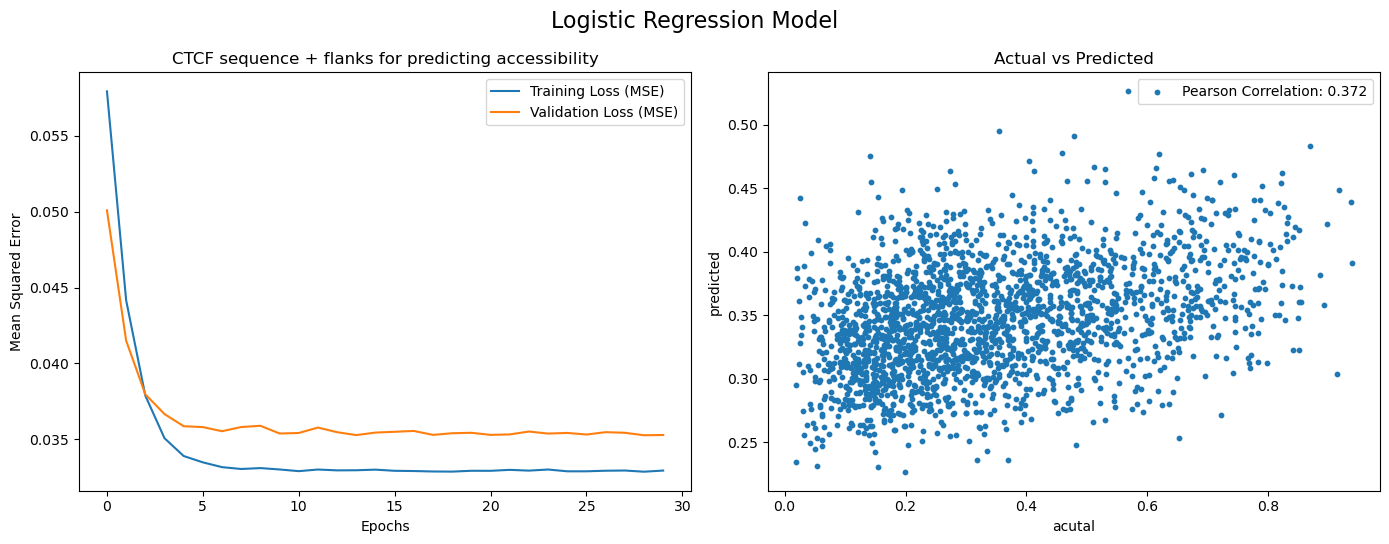

In [90]:
train_features, test_features, train_labels, test_labels = train_test_split(
            input_features, freqs_accessible, test_size=0.25,
            random_state=35)
model = Regressionmodel(train_features, 0.001, activation = 'sigmoid', )
history = model.fit(train_features, train_labels,
                             epochs = 30, batch_size=128, 
                             validation_data = (test_features, test_labels),verbose=0)
pearson_corr, _ = pearsonr(test_labels, val_predictions.flatten())
# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']
val_predictions = model.predict(test_features)



### plots
fig, axes = plt.subplots(1,2,figsize = (14,5.5))

axes[0].plot(mse, label='Training Loss (MSE)')
axes[0].plot(val_mse, label='Validation Loss (MSE)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].set_title('CTCF sequence + flanks for predicting accessibility')


axes[1].scatter(test_labels, val_predictions,s=10, label=f'Pearson Correlation: {pearson_corr:.3f}')
axes[1].set_xlabel('acutal')
axes[1].set_ylabel('predicted')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()

fig.suptitle('Logistic Regression Model', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


### using all there labels:

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
def Regressionmodel(features, learningrate, dense_layers = 1, activation=None, regularization_strength=0.01):
    model = Sequential()
    model.add(Input(shape=(features.shape[1], features.shape[2])))
    model.add(Flatten())
    
    # Add the dense layer with the given activation and regularization (if specified)
    model.add(Dense(dense_layers, activation=activation, kernel_regularizer=l2(regularization_strength))) 
    
    # Compile the model with MSE loss for continuous target values
    model.compile(optimizer=Adam(learning_rate=learningrate), loss='mean_squared_error')
    
    return model


In [99]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, freqs, test_size=0.25, random_state=35
)


70/70 [==============================] - 0s 412us/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


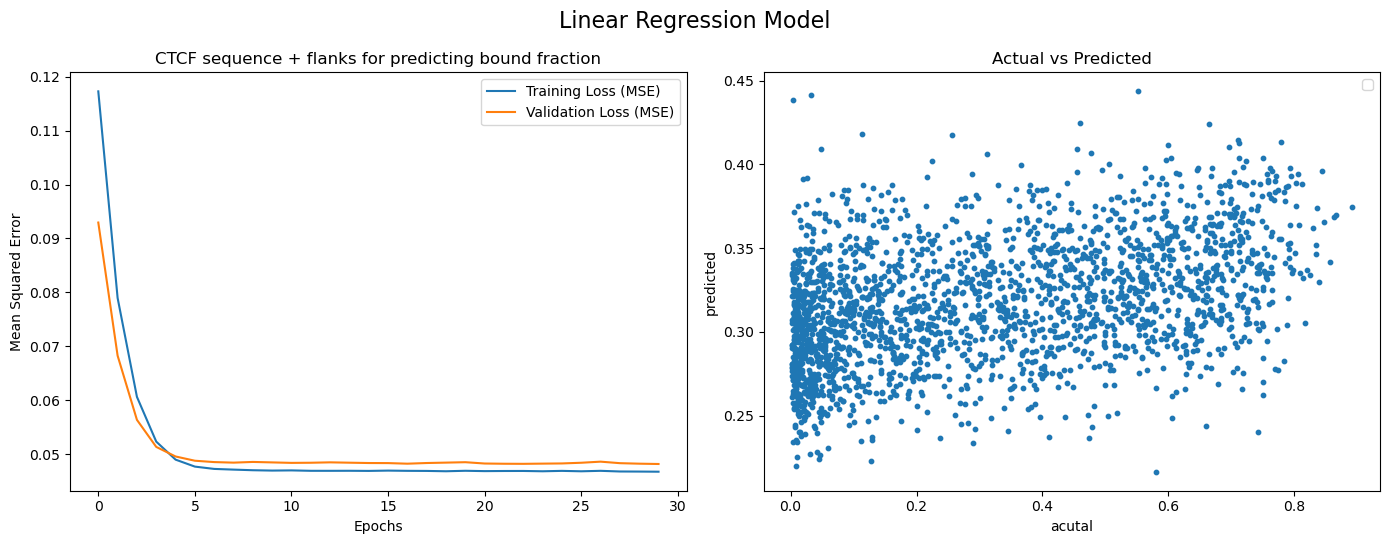

In [106]:
model = Regressionmodel(train_features, 0.001,  dense_layers=3, activation= 'sigmoid')
history = model.fit(train_features, train_labels, epochs = 30, batch_size=128, validation_data = (test_features, test_labels),verbose=0)
# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']
val_predictions = model.predict(test_features)
#pearson_corr, _ = pearsonr(test_labels, val_predictions.flatten())


### plots
fig, axes = plt.subplots(1,2,figsize = (14,5.5))

axes[1].scatter(test_labels[:,1], val_predictions[:,1],s=10)#, label=f'Pearson Correlation: {pearson_corr:.3f}')
axes[1].set_xlabel('acutal')
axes[1].set_ylabel('predicted')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()

axes[0].plot(mse, label='Training Loss (MSE)')
axes[0].plot(val_mse, label='Validation Loss (MSE)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()
axes[0].set_title('CTCF sequence + flanks for predicting bound fraction')




fig.suptitle('Linear Regression Model', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
